In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import uuid
import os
import scipy.stats as stats

In [2]:

csv_file = '/home/daria_ignatenko/big-storage/bbc_parsing/bbc_ai_detection.csv'
df = pd.read_csv(csv_file)

df['published_at'] = pd.to_datetime(df['published_at'])

df['year'] = df['published_at'].dt.year
df['month'] = df['published_at'].dt.to_period('M')
df['week'] = df['published_at'].dt.to_period('W')
df['day'] = df['published_at'].dt.date

releases = [
    ('GPT-3', pd.to_datetime('2020-05-01')),
    ('GPT-Neo', pd.to_datetime('2021-03-01')),
    ('Claude', pd.to_datetime('2021-12-01')),
    ('GPT-4', pd.to_datetime('2023-03-01')),
    ('Gemini', pd.to_datetime('2023-12-01')),
    ('Claude 3', pd.to_datetime('2024-03-01'))
]


/tmp/ipykernel_1110461/4198778811.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_at'].dt.to_period('M')
/tmp/ipykernel_1110461/4198778811.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['published_at'].dt.to_period('W')


In [3]:
df.head()

,url,title,published_at,updated_at,word_count,ai_prob,detector_model,inference_ts,year,month,week,day
0,https://www.bbc.com/news/articles/crmek723dz9o,Google owner reveals £5bn AI investment in UK ...,2025-09-16 04:00:15.758000+00:00,2025-09-16T09:44:20.473Z,669,0.898853,GLM,2025-09-25T11:25:57.048979,2025,2025-09,2025-09-15/2025-09-21,2025-09-16
1,https://www.bbc.com/news/uk-politics-68627916,Could artificial intelligence benefit democracy?,2024-03-29 01:27:15+00:00,2024-03-29T01:27:15.000Z,1067,0.795451,GLM,2025-09-25T11:26:05.256366,2024,2024-03,2024-03-25/2024-03-31,2024-03-29
2,https://www.bbc.com/news/business-68610711,Reddit: Social media firm's shares jump in sto...,2024-03-21 01:01:32+00:00,2024-03-21T22:35:26.000Z,713,0.792380,GPT-3/4,2025-09-25T11:26:11.319968,2024,2024-03,2024-03-18/2024-03-24,2024-03-21
3,https://www.bbc.com/news/articles/c0qw7z2v1pgo,Nvidia shares sink as Chinese AI app DeepSeek ...,2025-01-27 10:37:18.877000+00:00,2025-01-27T23:22:37.109Z,876,0.797442,GLM,2025-09-25T11:26:19.462663,2025,2025-01,2025-01-27/2025-02-02,2025-01-27
4,https://www.bbc.com/news/articles/cgr58dlnne5o,Meta urged to go further in its crackdown on '...,2025-06-12 11:28:16.814000+00:00,2025-06-12T14:07:53.303Z,586,0.862980,GLM,2025-09-25T11:26:25.202079,2025,2025-06,2025-06-09/2025-06-15,2025-06-12


сделаем дополнительный сбаланисированный датафрейм с примерно одинаковым количеством статей в год (но маленький):

In [4]:
balanced_df = df.groupby('year').apply(lambda x: x.sample(n=min(20, len(x)), random_state=42)).reset_index(drop=True)

print(balanced_df.head())
print(balanced_df['year'].value_counts())

                                                 url  \
0  https://www.bbc.com/future/article/20120528-ma...   
1  https://www.bbc.com/future/article/20120528-ho...   
2  https://www.bbc.com/future/article/20121218-wi...   
3  https://www.bbc.com/future/article/20120628-ca...   
4  https://www.bbc.com/future/article/20130709-bu...   

                                              title              published_at  \
0         From mach-20 glider to humming bird drone 2012-06-02 00:00:00+00:00   
1                    How algorithms shape our world 2012-05-30 00:00:00+00:00   
2                 Will we ever… have cyborg brains? 2012-12-18 00:00:00+00:00   
3          Will we ever… create intelligent robots? 2012-06-29 00:00:00+00:00   
4  4D printing: buildings that can change over time 2013-07-11 00:00:00+00:00   

                 updated_at  word_count   ai_prob detector_model  \
0  2022-02-28T12:59:50.051Z         127  0.113513          Human   
1  2022-02-28T12:59:44.406Z         109 

/tmp/ipykernel_128041/3570592075.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('year').apply(lambda x: x.sample(n=min(20, len(x)), random_state=42)).reset_index(drop=True)


In [3]:
output_dir = '/home/daria_ignatenko/big-storage/bbc_parsing/plots'
os.makedirs(output_dir, exist_ok=True)

Временной тренд с 30-дневным скользящим средним

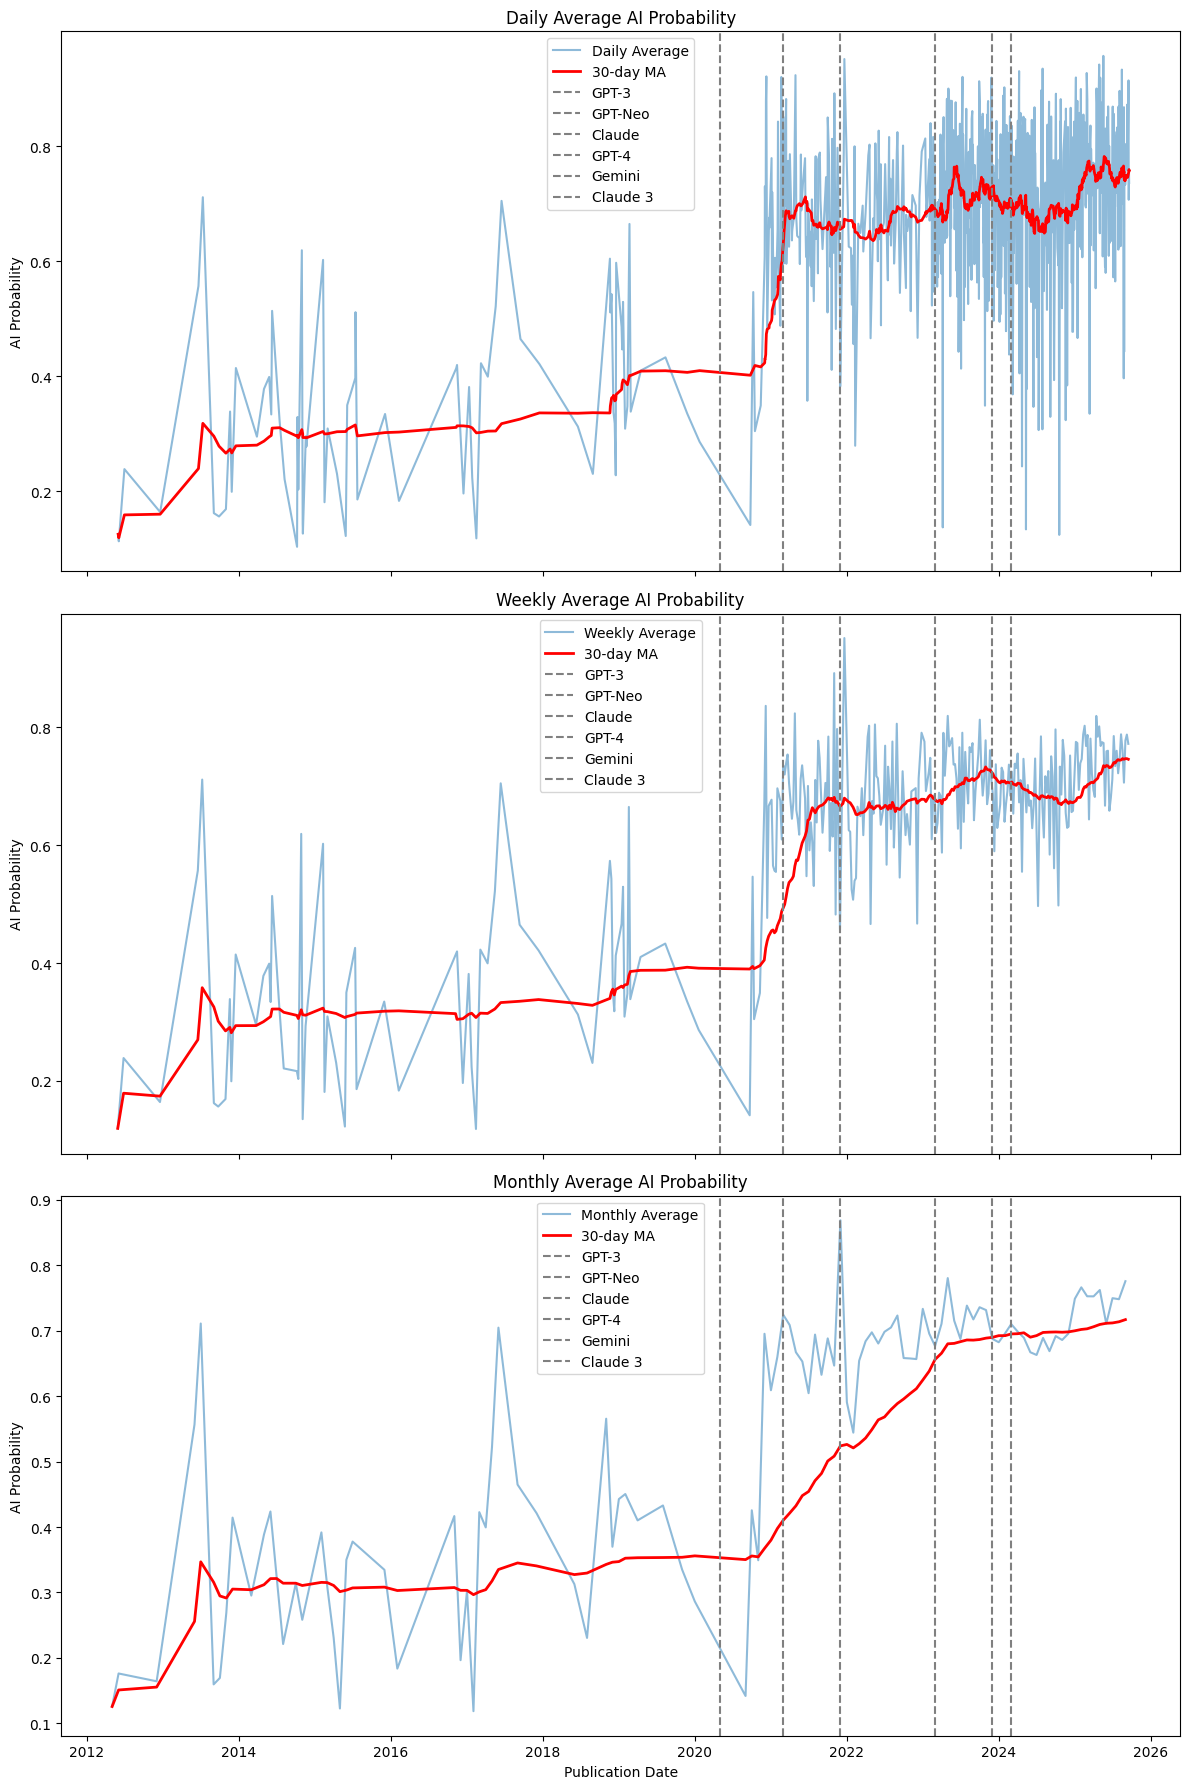

In [6]:

fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# дневной
daily_avg = df.groupby('day')['ai_prob'].mean().reset_index()
daily_avg['day'] = pd.to_datetime(daily_avg['day'])
daily_avg = daily_avg.sort_values('day')
daily_avg['ma_30'] = daily_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax1.plot(daily_avg['day'], daily_avg['ai_prob'], label='Daily Average', alpha=0.5)
ax1.plot(daily_avg['day'], daily_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax1.axvline(x=date, color='gray', linestyle='--', label=release if ax1.get_legend_handles_labels()[1].count(release) == 0 else '')
ax1.set_title('Daily Average AI Probability')
ax1.set_ylabel('AI Probability')
ax1.legend()

# недельный
weekly_avg = df.groupby('week')['ai_prob'].mean().reset_index()
weekly_avg['week'] = weekly_avg['week'].dt.start_time
weekly_avg = weekly_avg.sort_values('week')
weekly_avg['ma_30'] = weekly_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax2.plot(weekly_avg['week'], weekly_avg['ai_prob'], label='Weekly Average', alpha=0.5)
ax2.plot(weekly_avg['week'], weekly_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax2.axvline(x=date, color='gray', linestyle='--', label=release if ax2.get_legend_handles_labels()[1].count(release) == 0 else '')
ax2.set_title('Weekly Average AI Probability')
ax2.set_ylabel('AI Probability')
ax2.legend()

# месячный
monthly_avg = df.groupby('month')['ai_prob'].mean().reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.start_time
monthly_avg = monthly_avg.sort_values('month')
monthly_avg['ma_30'] = monthly_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax3.plot(monthly_avg['month'], monthly_avg['ai_prob'], label='Monthly Average', alpha=0.5)
ax3.plot(monthly_avg['month'], monthly_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax3.axvline(x=date, color='gray', linestyle='--', label=release if ax3.get_legend_handles_labels()[1].count(release) == 0 else '')
ax3.set_title('Monthly Average AI Probability')
ax3.set_xlabel('Publication Date')
ax3.set_ylabel('AI Probability')
ax3.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'trend_ai_prob_over_time_v2.png'))

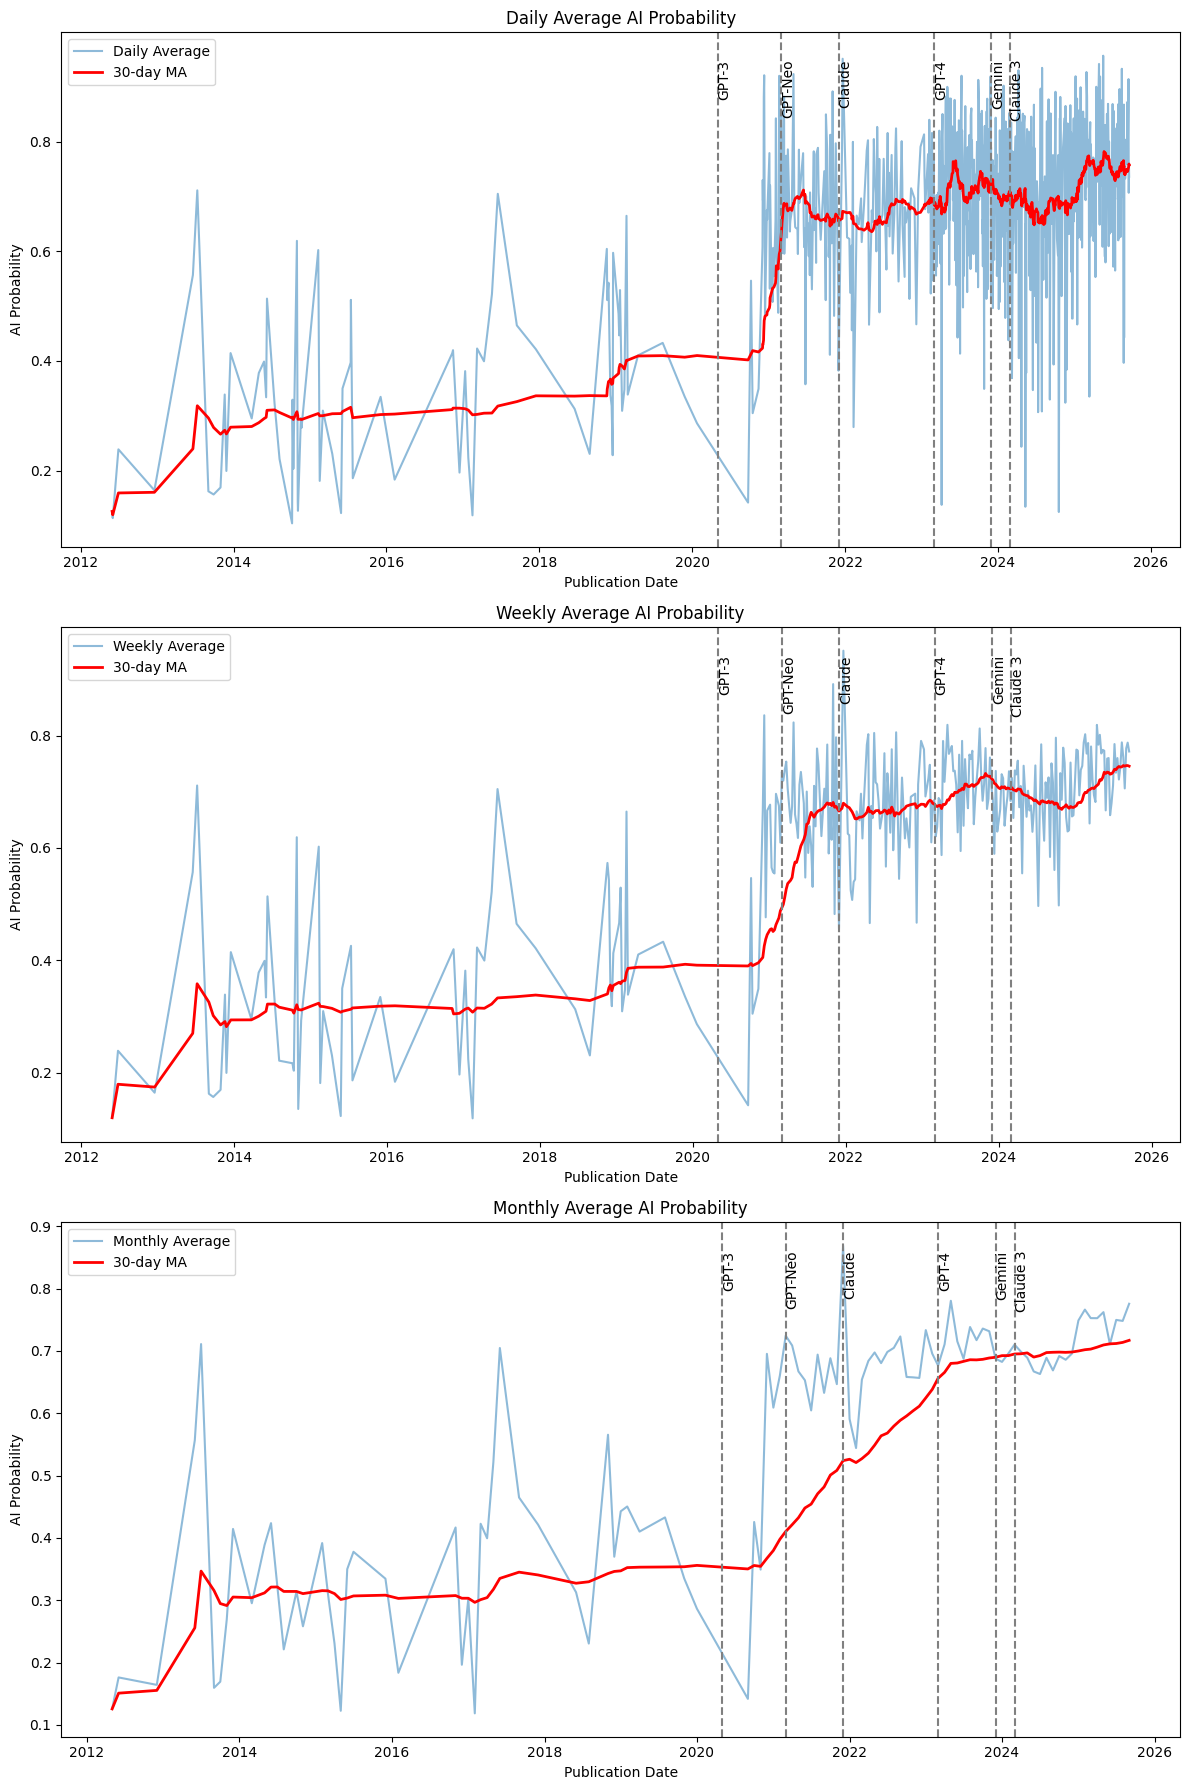

In [14]:
# 2 вариант
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=False)

# дневной
daily_avg = df.groupby('day')['ai_prob'].mean().reset_index()
daily_avg['day'] = pd.to_datetime(daily_avg['day'])
daily_avg = daily_avg.sort_values('day')
daily_avg['ma_30'] = daily_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax1.plot(daily_avg['day'], daily_avg['ai_prob'], label='Daily Average', alpha=0.5)
ax1.plot(daily_avg['day'], daily_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax1.axvline(x=date, color='gray', linestyle='--')
    ax1.text(date, ax1.get_ylim()[1] * 0.95, release, rotation=90, verticalalignment='top', fontsize=10, color='black')
ax1.set_title('Daily Average AI Probability')
ax1.set_xlabel('Publication Date')
ax1.set_ylabel('AI Probability')
ax1.legend()

# недельный
weekly_avg = df.groupby('week')['ai_prob'].mean().reset_index()
weekly_avg['week'] = weekly_avg['week'].dt.start_time
weekly_avg = weekly_avg.sort_values('week')
weekly_avg['ma_30'] = weekly_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax2.plot(weekly_avg['week'], weekly_avg['ai_prob'], label='Weekly Average', alpha=0.5)
ax2.plot(weekly_avg['week'], weekly_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax2.axvline(x=date, color='gray', linestyle='--')
    ax2.text(date, ax2.get_ylim()[1] * 0.95, release, rotation=90, verticalalignment='top', fontsize=10, color='black')
ax2.set_title('Weekly Average AI Probability')
ax2.set_xlabel('Publication Date')
ax2.set_ylabel('AI Probability')
ax2.legend()

# месячный
monthly_avg = df.groupby('month')['ai_prob'].mean().reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.start_time
monthly_avg = monthly_avg.sort_values('month')
monthly_avg['ma_30'] = monthly_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax3.plot(monthly_avg['month'], monthly_avg['ai_prob'], label='Monthly Average', alpha=0.5)
ax3.plot(monthly_avg['month'], monthly_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax3.axvline(x=date, color='gray', linestyle='--')
    ax3.text(date, ax3.get_ylim()[1] * 0.95, release, rotation=90, verticalalignment='top', fontsize=10, color='black')
ax3.set_title('Monthly Average AI Probability')
ax3.set_xlabel('Publication Date')
ax3.set_ylabel('AI Probability')
ax3.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'trend_ai_prob_over_time.png'))

редкие всплески ии до 2020 года -- скорее всего просто модель могла ложно задетектить человеческий текст. В целом там уверенность колеблется районе 20-40, что в целом говорит о том, что тексты человеческие

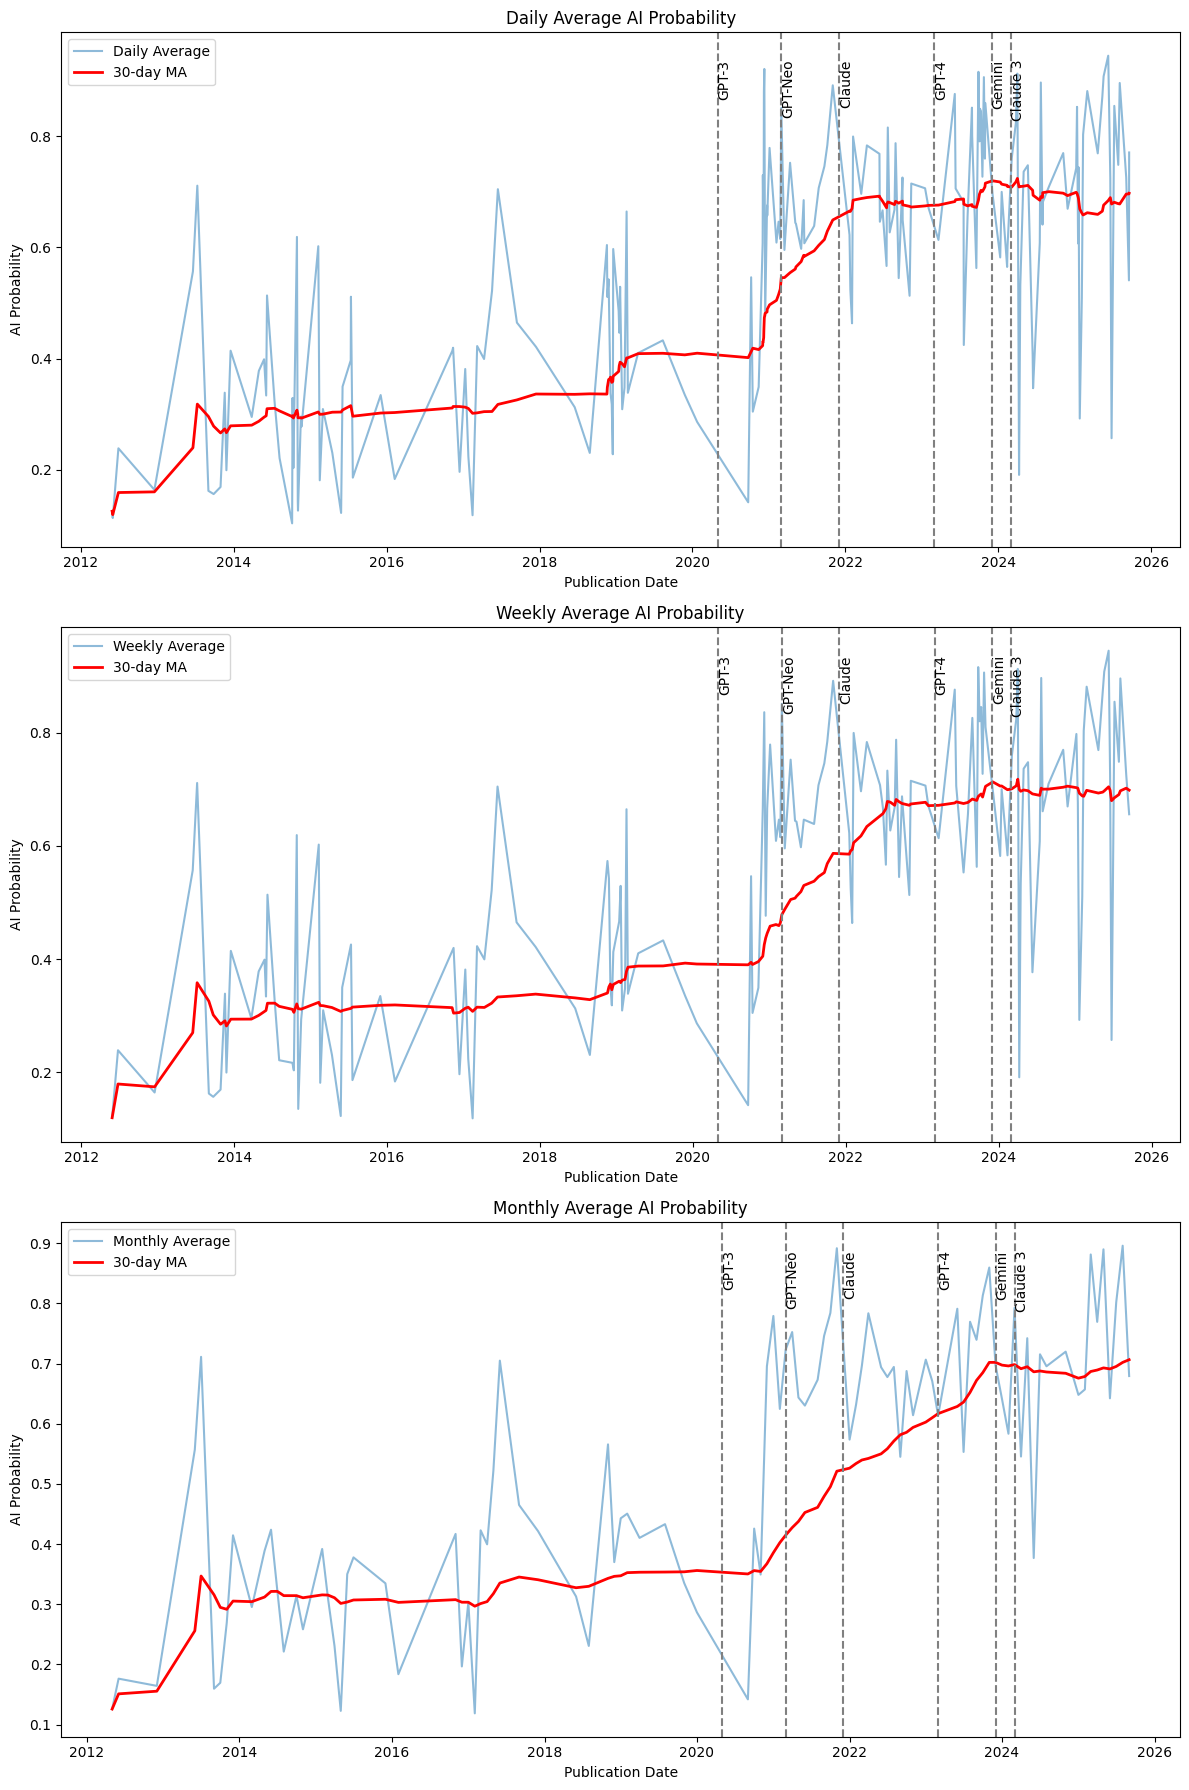

In [13]:
# тот же график для маленького сбалансированного датасета
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=False)

# дневной
daily_avg = balanced_df.groupby('day')['ai_prob'].mean().reset_index()
daily_avg['day'] = pd.to_datetime(daily_avg['day'])
daily_avg = daily_avg.sort_values('day')
daily_avg['ma_30'] = daily_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax1.plot(daily_avg['day'], daily_avg['ai_prob'], label='Daily Average', alpha=0.5)
ax1.plot(daily_avg['day'], daily_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax1.axvline(x=date, color='gray', linestyle='--')
    ax1.text(date, ax1.get_ylim()[1] * 0.95, release, rotation=90, verticalalignment='top', fontsize=10, color='black')
ax1.set_title('Daily Average AI Probability')
ax1.set_xlabel('Publication Date')
ax1.set_ylabel('AI Probability')
ax1.legend()

# недельный
weekly_avg = balanced_df.groupby('week')['ai_prob'].mean().reset_index()
weekly_avg['week'] = weekly_avg['week'].dt.start_time
weekly_avg = weekly_avg.sort_values('week')
weekly_avg['ma_30'] = weekly_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax2.plot(weekly_avg['week'], weekly_avg['ai_prob'], label='Weekly Average', alpha=0.5)
ax2.plot(weekly_avg['week'], weekly_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax2.axvline(x=date, color='gray', linestyle='--')
    ax2.text(date, ax2.get_ylim()[1] * 0.95, release, rotation=90, verticalalignment='top', fontsize=10, color='black')
ax2.set_title('Weekly Average AI Probability')
ax2.set_xlabel('Publication Date')
ax2.set_ylabel('AI Probability')
ax2.legend()

# месячный
monthly_avg = balanced_df.groupby('month')['ai_prob'].mean().reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.start_time
monthly_avg = monthly_avg.sort_values('month')
monthly_avg['ma_30'] = monthly_avg['ai_prob'].rolling(window=30, min_periods=1).mean()
ax3.plot(monthly_avg['month'], monthly_avg['ai_prob'], label='Monthly Average', alpha=0.5)
ax3.plot(monthly_avg['month'], monthly_avg['ma_30'], label='30-day MA', color='red', linewidth=2)
for release, date in releases:
    ax3.axvline(x=date, color='gray', linestyle='--')
    ax3.text(date, ax3.get_ylim()[1] * 0.95, release, rotation=90, verticalalignment='top', fontsize=10, color='black')
ax3.set_title('Monthly Average AI Probability')
ax3.set_xlabel('Publication Date')
ax3.set_ylabel('AI Probability')
ax3.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'trend_ai_prob_over_time_balanced.png'))

Зависимость ai_prob от длины статьи (word_count): scatter + binned mean

/tmp/ipykernel_780604/987915677.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_mean = df.groupby(bins)['ai_prob'].mean().reset_index()


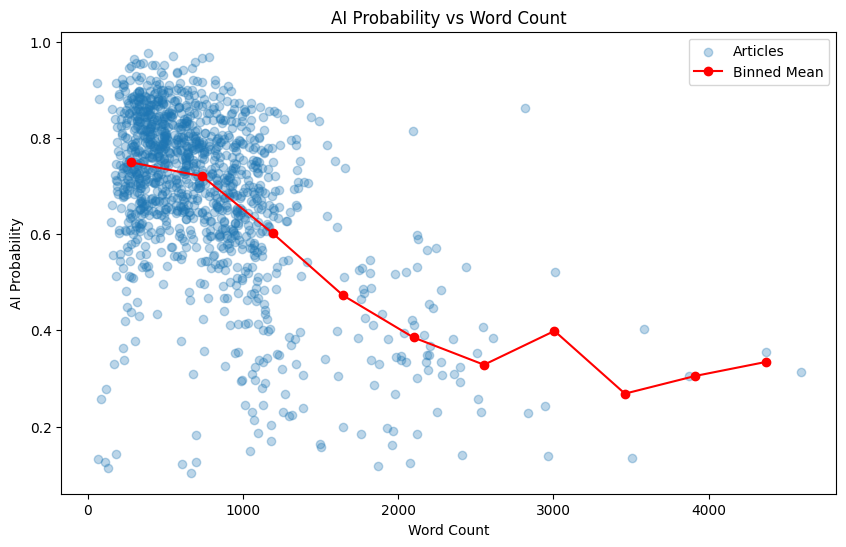

In [4]:

fig2, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['word_count'], df['ai_prob'], alpha=0.3, label='Articles')
bins = pd.cut(df['word_count'], bins=10)
binned_mean = df.groupby(bins)['ai_prob'].mean().reset_index()
binned_mean['word_count_mid'] = [interval.mid for interval in binned_mean['word_count']]
ax.plot(binned_mean['word_count_mid'], binned_mean['ai_prob'], color='red', marker='o', label='Binned Mean')
ax.set_xlabel('Word Count')
ax.set_ylabel('AI Probability')
ax.set_title('AI Probability vs Word Count')
ax.legend()


plt.savefig(os.path.join(output_dir, 'ai_prob_vs_length.png'))


In [4]:
# correlation coefficients

pearson_corr, pearson_p = stats.pearsonr(df['word_count'], df['ai_prob'])
spearman_corr, spearman_p = stats.spearmanr(df['word_count'], df['ai_prob'])

print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p})")
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_p})")

Pearson Correlation: -0.5265 (p-value: 1.3838839886044077e-87)
Spearman Correlation: -0.3995 (p-value: 8.941733009276863e-48)


Срезы по годам: boxplot/violin ai_prob по year

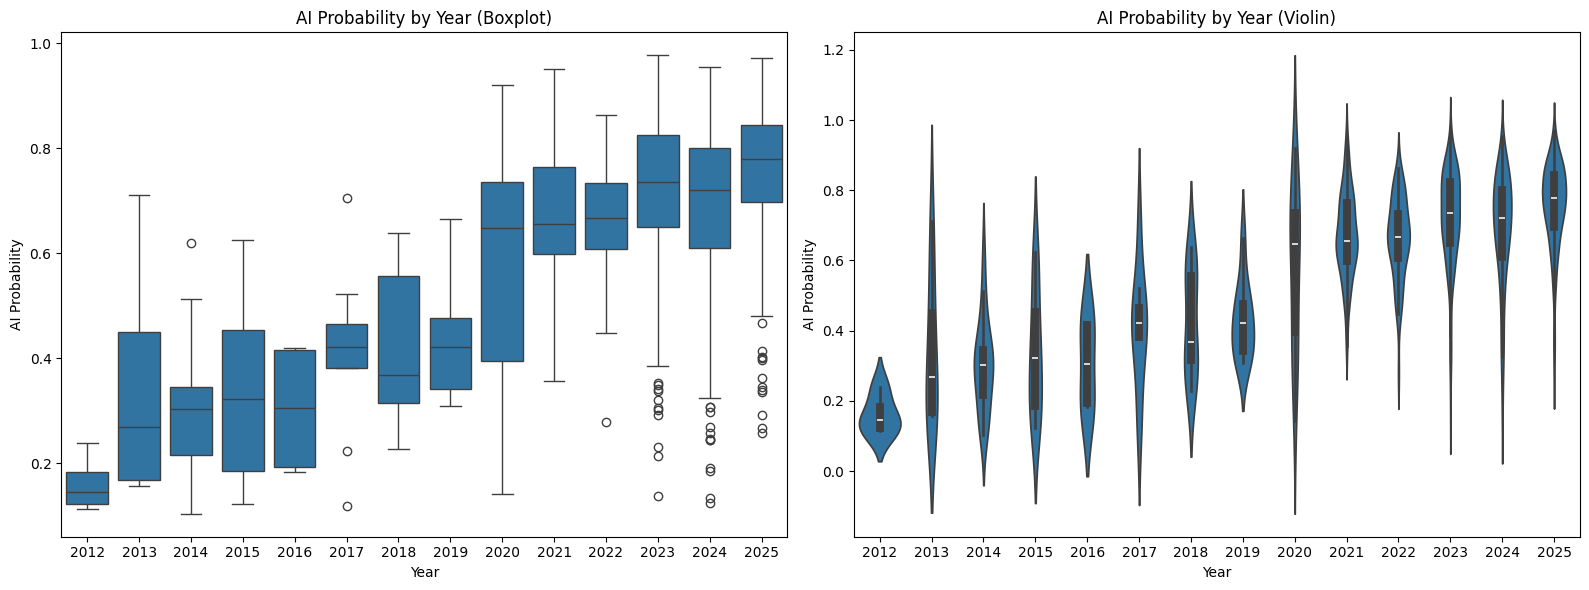

In [15]:
fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='year', y='ai_prob', data=df, ax=ax1)
ax1.set_title('AI Probability by Year (Boxplot)')
ax1.set_xlabel('Year')
ax1.set_ylabel('AI Probability')

sns.violinplot(x='year', y='ai_prob', data=df, ax=ax2)
ax2.set_title('AI Probability by Year (Violin)')
ax2.set_xlabel('Year')
ax2.set_ylabel('AI Probability')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'ai_prob_by_year.png'))

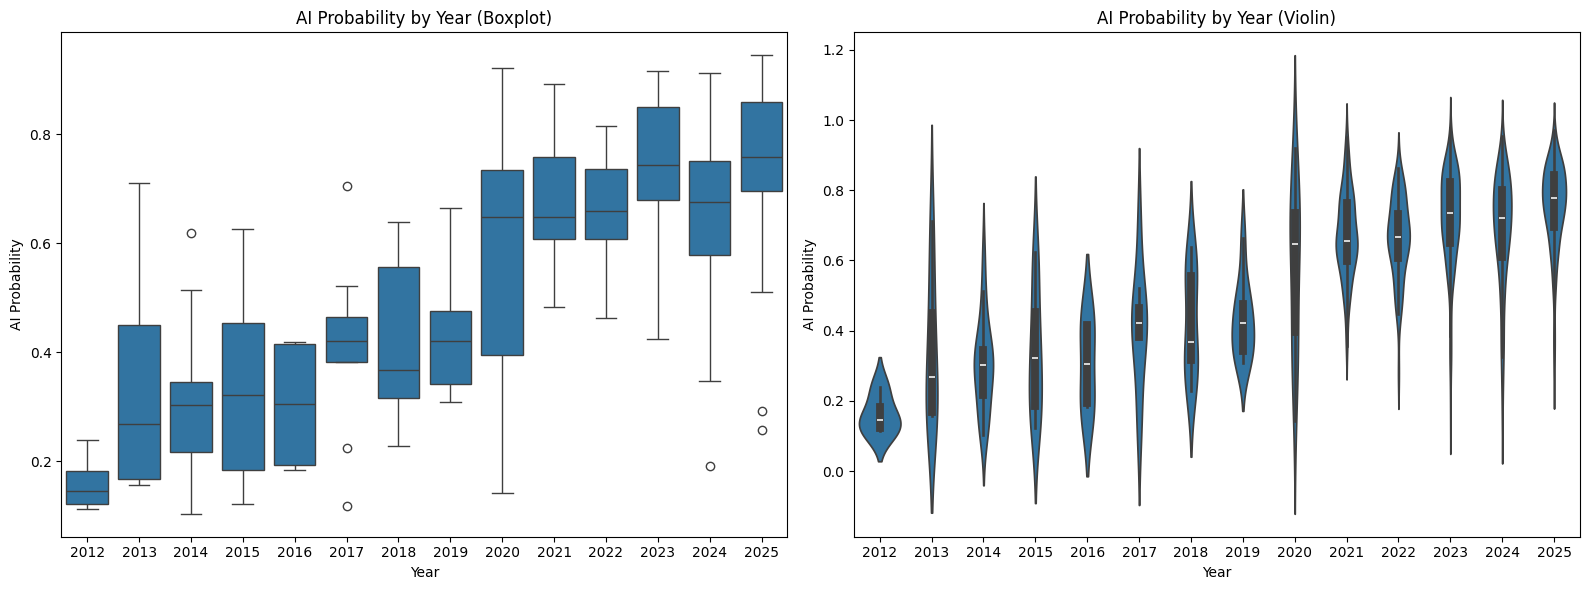

In [19]:
# тот же график для маленького сбалансированного датасета
fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='year', y='ai_prob', data=balanced_df, ax=ax1)
ax1.set_title('AI Probability by Year (Boxplot)')
ax1.set_xlabel('Year')
ax1.set_ylabel('AI Probability')

sns.violinplot(x='year', y='ai_prob', data=df, ax=ax2)
ax2.set_title('AI Probability by Year (Violin)')
ax2.set_xlabel('Year')
ax2.set_ylabel('AI Probability')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'ai_prob_by_year_balanced.png'))

количество статей в год

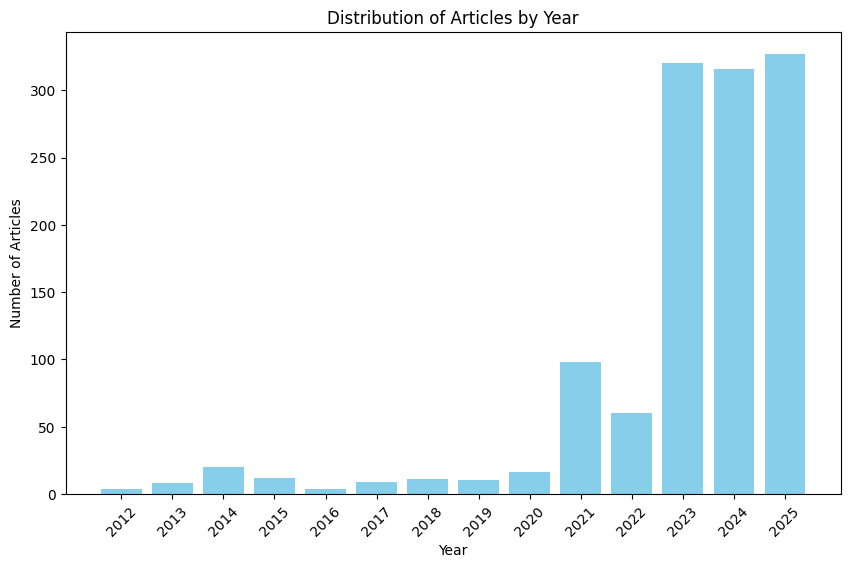

In [23]:
fig1, ax1 = plt.subplots(figsize=(10, 6))
articles_per_year = df['year'].value_counts().sort_index()
ax1.bar(articles_per_year.index, articles_per_year.values, color='skyblue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Articles')
ax1.set_title('Distribution of Articles by Year')
ax1.set_xticks(articles_per_year.index)
ax1.set_xticklabels(articles_per_year.index, rotation=45)
plt.savefig(os.path.join(output_dir, 'acrticles_by_year.png'))

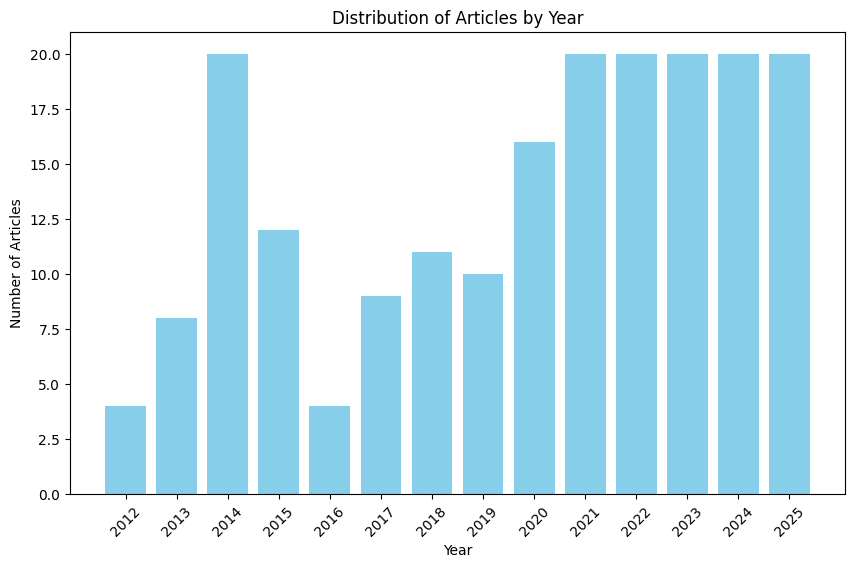

In [22]:
# тот же график для маленького сбалансированного датасета
fig1, ax1 = plt.subplots(figsize=(10, 6))
articles_per_year = balanced_df['year'].value_counts().sort_index()
ax1.bar(articles_per_year.index, articles_per_year.values, color='skyblue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Articles')
ax1.set_title('Distribution of Articles by Year')
ax1.set_xticks(articles_per_year.index)
ax1.set_xticklabels(articles_per_year.index, rotation=45)
plt.savefig(os.path.join(output_dir, 'acrticles_by_year_balanced.png'))

+предсказанные модели

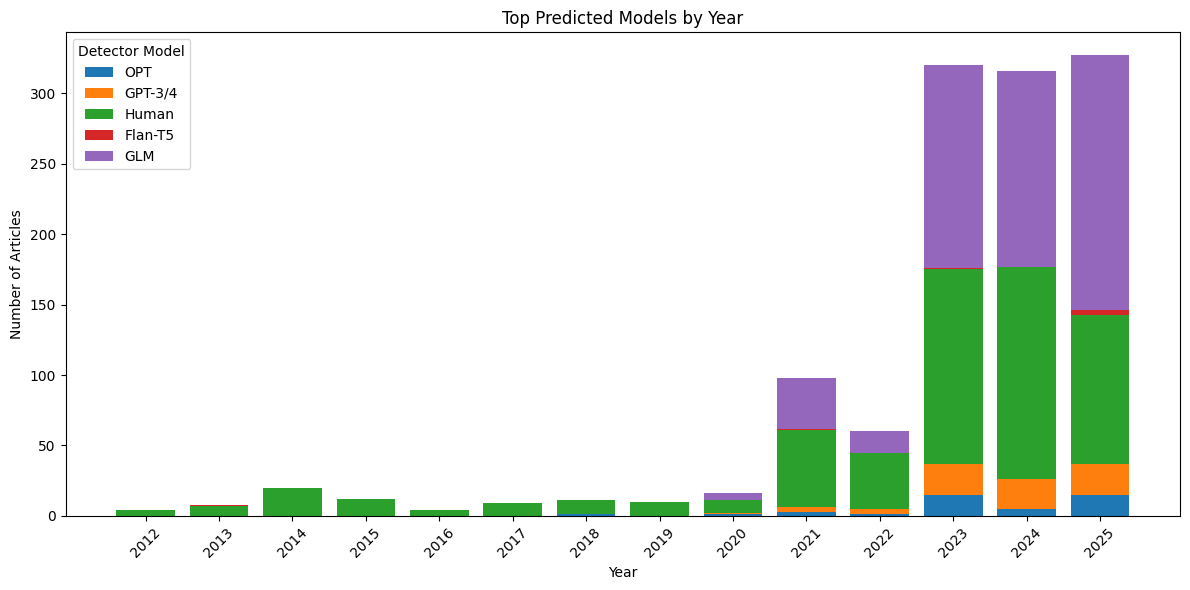

In [26]:

fig2, ax2 = plt.subplots(figsize=(12, 6))
model_freq = df.groupby(['year', 'detector_model']).size().unstack(fill_value=0)
top_models = {}
for year in model_freq.index:
    top_models[year] = model_freq.loc[year].nlargest(10).index.tolist()
all_top_models = list(set([model for year in top_models for model in top_models[year]]))
bottom = None
for model in all_top_models:
    values = [model_freq.loc[year, model] if model in model_freq.columns else 0 for year in model_freq.index]
    ax2.bar(model_freq.index, values, label=model, bottom=bottom)
    bottom = values if bottom is None else [b + v for b, v in zip(bottom, values)]
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Articles')
ax2.set_title('Top Predicted Models by Year')
ax2.set_xticks(model_freq.index)
ax2.set_xticklabels(model_freq.index, rotation=45)
ax2.legend(title='Detector Model')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'top_models_predicted_by_year.png'))

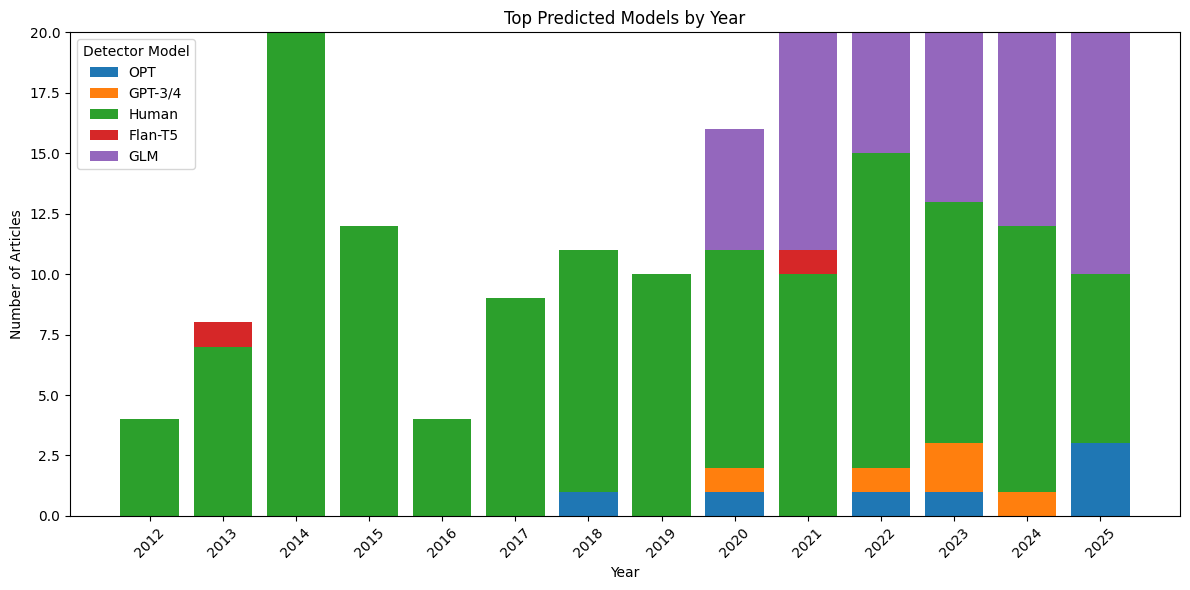

In [27]:
# тот же график для маленького сбалансированного датасета
fig2, ax2 = plt.subplots(figsize=(12, 6))
model_freq = balanced_df.groupby(['year', 'detector_model']).size().unstack(fill_value=0)
top_models = {}
for year in model_freq.index:
    top_models[year] = model_freq.loc[year].nlargest(10).index.tolist()
all_top_models = list(set([model for year in top_models for model in top_models[year]]))
bottom = None
for model in all_top_models:
    values = [model_freq.loc[year, model] if model in model_freq.columns else 0 for year in model_freq.index]
    ax2.bar(model_freq.index, values, label=model, bottom=bottom)
    bottom = values if bottom is None else [b + v for b, v in zip(bottom, values)]
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Articles')
ax2.set_title('Top Predicted Models by Year')
ax2.set_xticks(model_freq.index)
ax2.set_xticklabels(model_freq.index, rotation=45)
ax2.legend(title='Detector Model')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'top_models_predicted_by_year_balanced.png'))

- Временные ряды: на графике "перелом" совпадает с концом 2020 - началом 2021, между выходом GPT-3 и GPT-Neo, после которого среднее значение ai_prob резко увеличивается и так и остается высоким до 2025
- С длиной статьи отрицательная зависимость: чем длиннее статья, тем меньше вероятность, что она сгенерирована
- Срезы по годам: очень большой разброс значений ai_prob для 2020 года, в более ранних статьях он меньше 0.5, в более поздних -- больше 0.6
- На более маленькой подвыборке, со сбалансированным количество текстов по годам закономерности остаются те же